# Loading Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



# Importing required libraries
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import Model
from keras import regularizers

# gensim
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

from wordcloud import WordCloud
from collections import Counter

import re
import string

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# defining function to clean text and retrive closs-validation datasets
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('all')

stopwords = set(stopwords.words('english'))

targets = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

word_counter={}

'''
def cleantxt(c):
    punct = "?!/-.,#$%\()*+-/:;<=>@[\\]^_`{|}`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°\
£€\×™√²—–&'
    words = c.split()
    filtered_words = []
    wn = WordNetLemmatizer()
    for word in words:
        # add useful punctuation
        if '?' in word:
            filtered_words.append('?')
        if '!' in word:
            filtered_words.append('!')
        # replace punctuation with empty string
        for p in punct:
            if p in word:
                word = word.replace(p, ' ') 
        # if words not in stopwords add
        if word.lower() not in stopwords:
            filtered_words.append(wn.lemmatize(word.lower()))
        # ignore words with empty string
        if len(word)==0 or word==' ':
            filtered_words.remove(word)
    return ' '.join(filtered_words)
'''

def clean_txt(text):
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in (stopwords)])

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text


def process_data():
    
    df = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip")
    
    # Clean the text
    #df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))
    #df['comment_text'] = df['comment_text'].apply(lambda x : cleantxt(x))
    #df['comment_text'] = df['comment_text'].fillna(' ')
    
    # separate explanatory and dependent variables
    
    

    for col in targets:    
        text = Counter()        

        # applying the clean-function to each column's comments and ...
        df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))
        df[df[col] == 1]['comment_text'].apply(lambda t: text.update(clean_txt(t).split()))

        # combining all to one dataframe
        word_counter[col] = pd.DataFrame.from_dict(text, orient='index')\
                                            .rename(columns={0: 'count'})\
                                            .sort_values('count', ascending=False)

                                             
    df['comment_text'] = df['comment_text'].fillna(' ')
                                             
    X = df['comment_text']
    y = df[targets]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=247)
    
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = process_data()

In [4]:
X_train.head()

40101    hello bihn i hope you will not miss out on my ...
70038    oh now i get it thanks uncle ed we just have t...
3189     10 october 2013 utc this is a non trivial prob...
44473    542nd parachute infantry regiment united state...
26537    happy subst pagename day user subst pagename h...
Name: comment_text, dtype: object

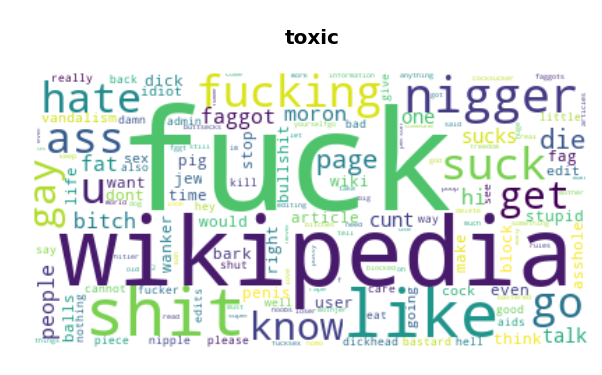

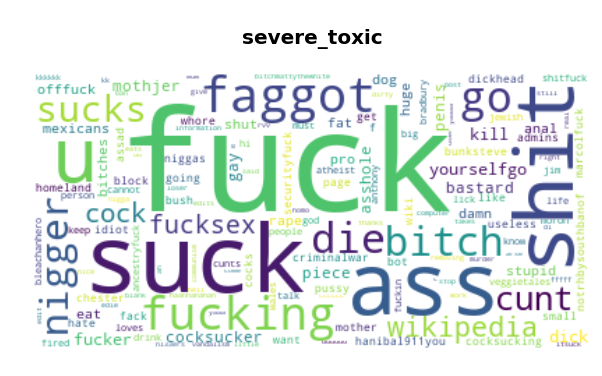

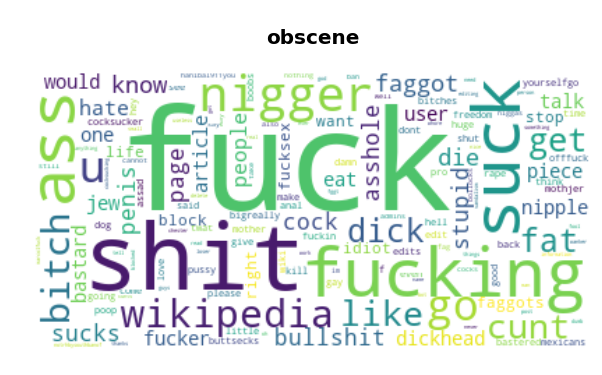

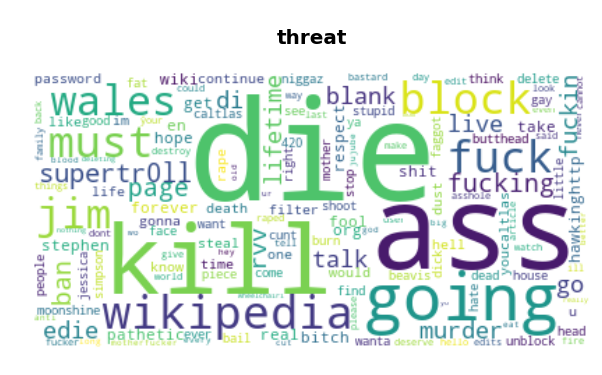

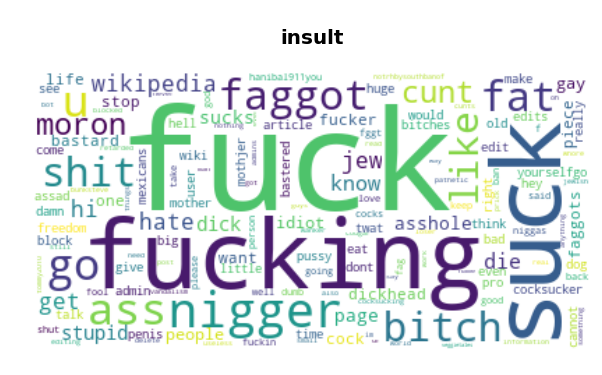

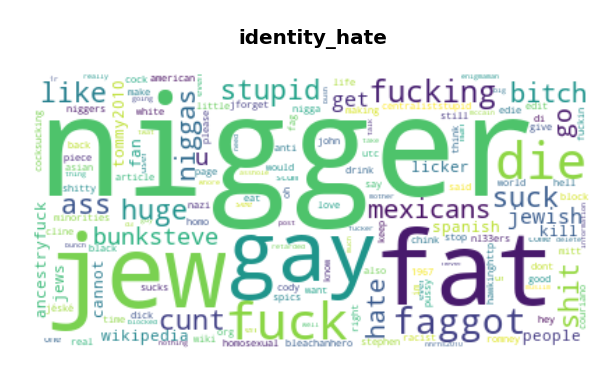

In [5]:
for col in word_counter:    
    wc_list = word_counter[col]
    
    wordcloud = WordCloud(background_color='white', max_words=150, max_font_size=100, random_state=4)\
                          .generate_from_frequencies(wc_list.to_dict()['count'])

    fig = plt.figure(figsize=(10, 8))
    plt.title('\n' + col + '\n', fontsize=20, fontweight='bold')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

In [6]:
# Tokenization

NUM_WORDS = 20000

tokenizer = Tokenizer(num_words=NUM_WORDS)

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

In [7]:
# Index Representation
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [8]:
# Most sentence length is 30, choose maxlen=50-100
maxlen=100

X_train = pad_sequences(sequences_train,maxlen=maxlen)
X_test = pad_sequences(sequences_test,maxlen=maxlen)

# Convert target to array
y_train = np.asarray(y_train)

# Printing shape
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

Shape of X_train: (127656, 100)
Shape of y_train: (127656, 6)


In [9]:
# Use pretrain Word2Vec model from Google https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# Contains 300-dimensional vectors for 3 million words and phrases 

word_vectors = KeyedVectors.load_word2vec_format('../input/word2vecnegative300/GoogleNews-vectors-negative300.bin', binary=True)

In [10]:
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,(NUM_WORDS))

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))


for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        vec = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i]=vec

embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [12]:
filter_sizes = [3,4]
num_filters = 100
drop = 0.4

inputs = Input(shape=(maxlen,))
embedding = embedding_layer(inputs)
reshape = Reshape((maxlen,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((maxlen - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((maxlen - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((2*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
conc = Dense(40)(dropout)
output = Dense(units=6, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(conc)

# this creates a model that includes
model = Model(inputs, output)

In [13]:
# Compiling Model using optimizer
model.compile(loss='binary_crossentropy',optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 300, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 98, 1, 100)   90100       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

In [14]:
# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
model.fit(X_train, y_train, batch_size=400, epochs=20, verbose=2, validation_split=0.2, callbacks=callbacks)

Train on 102124 samples, validate on 25532 samples
Epoch 1/20
 - 12s - loss: 0.1813 - val_loss: 0.1002
Epoch 2/20
 - 7s - loss: 0.0886 - val_loss: 0.0784
Epoch 3/20
 - 7s - loss: 0.0760 - val_loss: 0.0704
Epoch 4/20
 - 7s - loss: 0.0711 - val_loss: 0.0693
Epoch 5/20
 - 7s - loss: 0.0681 - val_loss: 0.0689
Epoch 6/20
 - 7s - loss: 0.0660 - val_loss: 0.0689


In [15]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [16]:
from sklearn import metrics

AUC = np.zeros((2,6))

for i,x in enumerate(targets):
    auc = np.array([metrics.roc_auc_score(y_train[:,i], pred_train[:,i]),
                    metrics.roc_auc_score(y_test[x], pred_test[:,i])])
    print(x,"Train AUC:",auc[0],"Test AUC:",auc[1])
    AUC[:,i] = auc
    
avg_auc = AUC.mean(axis=1)
print("Average Train AUC:",avg_auc[0],"Average Test AUC:",avg_auc[1])

toxic Train AUC: 0.9812031532998549 Test AUC: 0.9689154169967452
severe_toxic Train AUC: 0.9863225197781296 Test AUC: 0.9816202271292819
obscene Train AUC: 0.989650099612367 Test AUC: 0.9853626337102241
threat Train AUC: 0.945147228075246 Test AUC: 0.9466226760932182
insult Train AUC: 0.9834621950924407 Test AUC: 0.9775800942365741
identity_hate Train AUC: 0.9528300839749989 Test AUC: 0.9512811556971269
Average Train AUC: 0.9731025466388394 Average Test AUC: 0.9685637006438617
